In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime
#from learntools.time_series.style import *
from pathlib import Path
DIR = Path('./data/')

test this one: https://www.kaggle.com/code/antonellomartiello/store-sales-eda#Prophet
with holidays

In [35]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

c:\Program Files\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


https://www.kaggle.com/code/javigallego/time-series-forecasting-tutorial#1-%7C-Introduction-to-Date-and-Time

Data loading and merging

In [25]:
train = pd.read_csv(DIR / 'train.csv')
test = pd.read_csv(DIR / 'test.csv')
stores = pd.read_csv(DIR / 'stores.csv')
oil = pd.read_csv(DIR / 'oil.csv')
transactions =  pd.read_csv(DIR / 'transactions.csv')
holidays_events = pd.read_csv(DIR / 'holidays_events.csv')

In [50]:
holidays_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [27]:
df_data = pd.concat([train,test], sort=True)
df_data = df_data.merge(stores, how="left", on='store_nbr')   
df_data = df_data.merge(oil, how="left", on='date')      
df_data = df_data.merge(transactions, how="left", on=['date','store_nbr'])  
df_data = df_data.merge(holidays_events,on='date',how='left')
df_data = df_data.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

In [28]:
df_data.head()

,date,family,id,onpromotion,sales,store_nbr,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,locale,locale_name,description,transferred
0,2013-01-01,AUTOMOTIVE,0,0,0.0,1,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,BABY CARE,1,0,0.0,1,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,BEAUTY,2,0,0.0,1,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,BEVERAGES,3,0,0.0,1,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,BOOKS,4,0,0.0,1,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [29]:
df_data.date = pd.to_datetime(df_data.date)
df_data['year'] = df_data['date'].dt.year
df_data['month'] = df_data['date'].dt.month
df_data['week'] = df_data['date'].dt.isocalendar().week
df_data['quarter'] = df_data['date'].dt.quarter
df_data['day_of_week'] = df_data['date'].dt.day_name()
df_data.head()

,date,family,id,onpromotion,sales,store_nbr,city,state,store_type,cluster,...,holiday_type,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,2013-01-01,AUTOMOTIVE,0,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
1,2013-01-01,BABY CARE,1,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
2,2013-01-01,BEAUTY,2,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
3,2013-01-01,BEVERAGES,3,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
4,2013-01-01,BOOKS,4,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday


# Missing values
* oil: via backfill
* transactions: fil with 0
* holidays: empty then workingdays, transferred emypt = Flase, rest empyt string


In [30]:
df_data['dcoilwtico'] = df_data['dcoilwtico'].fillna(method='bfill')
df_data.dcoilwtico.isnull().sum()

0

In [32]:
df_data.transactions = df_data.transactions.replace(np.nan,0)   

In [34]:
df_data[['locale','locale_name', 'description']] = df_data[['locale','locale_name', 'description']].replace(np.nan,'')
df_data['holiday_type'] = df_data['holiday_type'].replace(np.nan,'Working Day')
df_data['transferred'] = df_data['transferred'].replace(np.nan,False)

# Feature Transformation

In [36]:
non_numerical_cols =  [col for col in df_data.columns if df_data[col].dtype == 'object']
for feature in non_numerical_cols:        
    df_data[feature] = LabelEncoder().fit_transform(df_data[feature])
df_data.head().style.set_properties(subset=non_numerical_cols, **{'background-color': '#F1C40F'})

,date,family,id,onpromotion,sales,store_nbr,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,2013-01-01 00:00:00,0,0,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5
1,2013-01-01 00:00:00,1,1,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5
2,2013-01-01 00:00:00,2,2,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5
3,2013-01-01 00:00:00,3,3,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5
4,2013-01-01 00:00:00,4,4,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5


In [37]:
low_card_cols = [col for col in non_numerical_cols if len(df_data[col].unique()) < 15]

In [38]:
encoded_features = []

for feature in low_card_cols:
    encoded_feat = OneHotEncoder().fit_transform(df_data[feature].values.reshape(-1, 1)).toarray()
    n = df_data[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df_data.index
    encoded_features.append(encoded_df)

df_data = pd.concat([df_data, *encoded_features[:9]], axis=1)

In [39]:
df_data.head().style.set_properties(subset=low_card_cols, **{'background-color': '#F1C40F'})


,date,family,id,onpromotion,sales,store_nbr,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week,store_type_1,store_type_2,store_type_3,store_type_4,store_type_5,holiday_type_1,holiday_type_2,holiday_type_3,holiday_type_4,holiday_type_5,holiday_type_6,holiday_type_7,locale_1,locale_2,locale_3,locale_4,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7
0,2013-01-01 00:00:00,0,0,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,2013-01-01 00:00:00,1,1,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,2013-01-01 00:00:00,2,2,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
3,2013-01-01 00:00:00,3,3,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,2013-01-01 00:00:00,4,4,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [40]:
df_data = df_data.drop(low_card_cols,axis=1)

# Crossvalidation

In [41]:
from sklearn.model_selection import TimeSeriesSplit
N_SPLITS = 3

X = df_data['date']
y = df_data['sales']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

# Modelling

In [48]:
train.head()

,ds,y
0,2013-01-01,1.409438
1,2013-01-02,278.390807
2,2013-01-03,202.840197
3,2013-01-04,198.911154
4,2013-01-05,267.873244


In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from prophet import Prophet

train = df_data[df_data['date']<= datetime.datetime(2017,8,15)][['date','sales']].groupby('date').mean().reset_index('date')
train.columns = ['ds', 'y']
x_valid = pd.DataFrame(df_data[df_data['date']>= datetime.datetime(2017,8,16)]['date'])
x_valid.columns = ['ds']

# Train the model
model = Prophet()
model.fit(train)
y_pred = model.predict(x_valid)

13:21:06 - cmdstanpy - INFO - Chain [1] start processing
13:21:07 - cmdstanpy - INFO - Chain [1] done processing


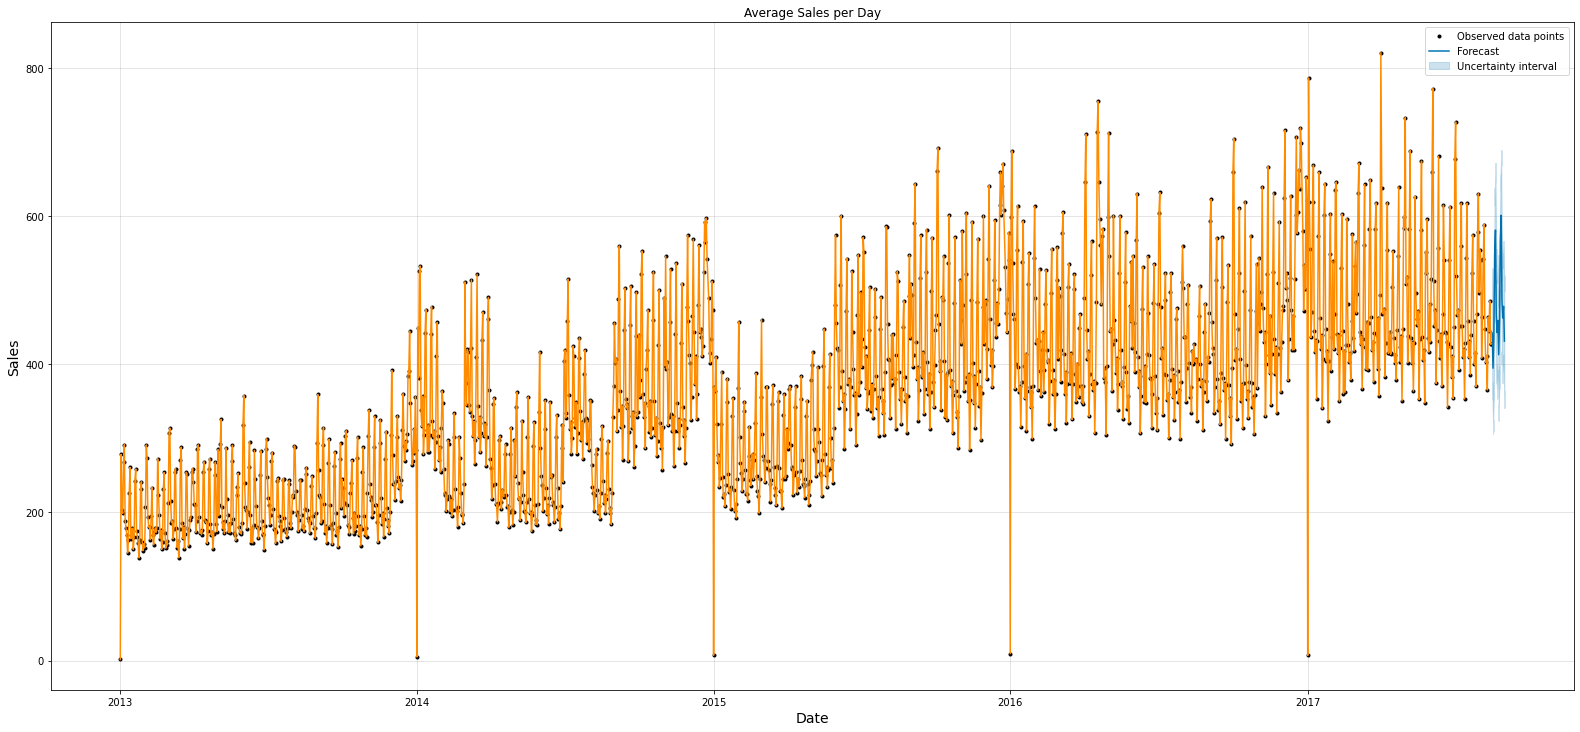

In [47]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(22)

model.plot(y_pred, ax=ax)
sns.lineplot(x=train['ds'], y=train['y'], ax=ax, color='darkorange') #navajowhite

#ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)
ax.set_title('Average Sales per Day')

plt.show()